# Transfer Learning: Fine Tuning

In [1]:
import tensorflow as tf

# List all physical devices
physical_devices = tf.config.list_physical_devices('GPU')

# Check if any GPUs are available
if physical_devices:
    print(f"GPUs available: {[device.name for device in physical_devices]}")
else:
    print("No GPUs available.")


GPUs available: ['/physical_device:GPU:0']


In [2]:
# Now we can use helper functions we have used before but instead of writing it again we can just import them

import helper_functions as hp

## Let's download the Data

In [3]:
hp.walk_through_dir("../Datasets/10_food_classes_10_percent")

There are 2 directories and 1 images in '../Datasets/10_food_classes_10_percent'.
There are 10 directories and 0 images in '../Datasets/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 image

In [4]:
# Create training and test paths

train_dir = "../Datasets/10_food_classes_10_percent/train"
test_dir = "../Datasets/10_food_classes_10_percent/test"

In [5]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE
                                                                            )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory= test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE
                                                                            )

Found 750 files belonging to 10 classes.


2025-09-24 10:42:24.124601: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-09-24 10:42:24.124624: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-24 10:42:24.124638: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-24 10:42:24.124672: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-24 10:42:24.124683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
# Check out class names of our dataset

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# See an example of a batch of data (.take does this)

for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[ 88.87245     93.87245     87.87245   ]
   [ 81.09693     86.09693     80.09693   ]
   [ 91.56633     96.78061     89.13776   ]
   ...
   [117.01032    122.581795   120.79606   ]
   [113.68364    119.68364    117.68364   ]
   [114.03577    123.03577    122.03577   ]]

  [[ 91.06632     96.06632     90.06632   ]
   [ 87.35714     92.35714     85.35714   ]
   [ 91.525505    96.73979     89.09693   ]
   ...
   [110.73988    116.73988    114.73988   ]
   [108.57655    114.57655    112.57655   ]
   [114.826485   120.826485   120.826485  ]]

  [[ 94.158165    99.158165    92.94388   ]
   [ 91.2704      96.2704      89.2704    ]
   [ 88.92347     94.92347     84.831635  ]
   ...
   [104.14297    110.14297    108.14297   ]
   [116.98969    122.98969    120.98969   ]
   [110.83177    116.83177    114.83177   ]]

  ...

  [[ 27.862324    22.862324    16.862324  ]
   [ 32.515434    29.515436    22.515436  ]
   [ 28.734793    28.163364    22.949078  ]
   ...
   [116.         101.   

2025-09-24 10:42:24.475509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model 0: Building a Transfer learning feature extraction model using a Keras Functional API (instead of the Sequential API)

In [9]:
# 1. Create Base model using tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our Model
inputs = tf.keras.layers.Input(shape=(224,224,3), name = "input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you find out with trial and error. You do not have to for Efficient(s))
# x = tf.keras.layers.Rescaling(1./255)(inputs) # Do not need right now since we are using Efficienet

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")
      
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling 2D:{x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs and the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile for the Model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy,
                optimizer = "Adam",
                metrics = ["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                #  steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25*len(test_data)), #to validate quicker
                                 callbacks = [hp.create_tensorboard_callback(dir_name="transfer_learning",
                                                                             experiment_name= "10_percent_feature_extraction")])

Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after Global Average Pooling 2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250924-104226
Epoch 1/5


/Users/alejandrocortes/opt/miniconda3/envs/alex/lib/python3.10/site-packages/keras/src/callbacks/tensorboard.py:668: UserWarning: Model failed to serialize as JSON. Ignoring... CategoricalCrossentropy.get_config() missing 1 required positional argument: 'self'
  warnings.warn(f"Model failed to serialize as JSON. Ignoring... {exc}")
2025-09-24 10:42:27.272044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 429ms/step - accuracy: 0.2914 - loss: 2.0355 - val_accuracy: 0.7599 - val_loss: 1.2877
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.7344 - loss: 1.2086 - val_accuracy: 0.8207 - val_loss: 0.8565
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.8307 - loss: 0.8390 - val_accuracy: 0.8405 - val_loss: 0.6949
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.8584 - loss: 0.7005 - val_accuracy: 0.8520 - val_loss: 0.6397
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.8633 - loss: 0.6019 - val_accuracy: 0.8088 - val_loss: 0.6288


2025-09-24 10:43:03.509338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-09-24 10:43:03.509361: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14846290578385053047
2025-09-24 10:43:03.509425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[ArgMax/_6]]
/Users/alejandrocortes/opt/miniconda3/envs/alex/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [15]:
next(test_data.as_numpy_iterator())

(array([[[[4.07755089e+01, 3.18469372e+01, 6.48979568e+00],
          [4.89795914e+01, 3.21989784e+01, 1.21020412e+01],
          [7.27193909e+01, 4.38622475e+01, 2.96479607e+01],
          ...,
          [7.14846497e+01, 4.26274643e+01, 1.85509415e+01],
          [8.13777924e+01, 4.18828163e+01, 2.13573265e+01],
          [1.02703896e+02, 5.01476860e+01, 3.38620071e+01]],
 
         [[4.98265305e+01, 3.78979607e+01, 1.58979616e+01],
          [4.55561256e+01, 2.67091846e+01, 9.63265419e+00],
          [5.28061180e+01, 2.85510159e+01, 1.30050993e+01],
          ...,
          [8.03977661e+01, 4.78314972e+01, 2.65866261e+01],
          [7.54847183e+01, 3.80560799e+01, 1.92653008e+01],
          [7.87092743e+01, 3.42091713e+01, 1.86377773e+01]],
 
         [[5.39336739e+01, 3.42908134e+01, 1.79336739e+01],
          [6.45969467e+01, 4.49540863e+01, 3.03826561e+01],
          [6.62397919e+01, 4.41173477e+01, 2.96428566e+01],
          ...,
          [8.29538879e+01, 5.01682625e+01, 3.0739

In [10]:
# Evaluate on the full test dataset:

model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.8699 - loss: 0.5371


[0.5587034225463867, 0.8600000143051147]

In [13]:
# Check the layers in our base model

for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer_1
1 rescaling_1
2 normalization_1
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_con

In [14]:
# Get a summary from the base model

base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, None,      │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization_1[… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [15]:
model_0.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [16]:
import pandas as pd
pd.DataFrame(history_10_percent.history)

,accuracy,loss,val_accuracy,val_loss
0,0.417333,1.868512,0.725329,1.308843
1,0.760000,1.144767,0.809211,0.898301
2,0.821333,0.830065,0.838816,0.733784
3,0.842667,0.687986,0.865132,0.623273
4,0.864000,0.593315,0.867647,0.478775


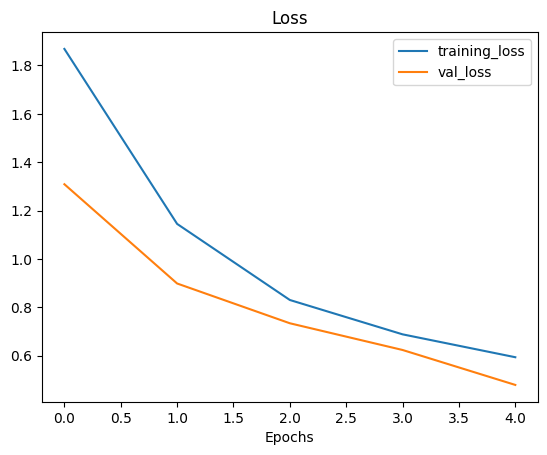

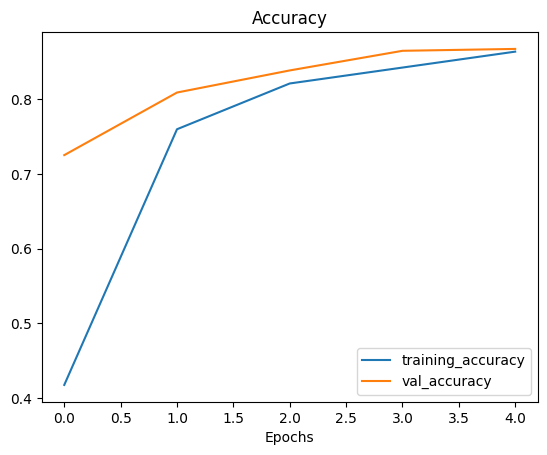

In [17]:
# Check out our model's training curves
hp.plot_loss_curves(history_10_percent)

# something weird happens in some epochs, but let's continue...

## Getting a Feature Vector from a trained model

Let's demonstrate the Global Average Pooling 2D Layer
From (None, 7, 7, 1280) to (None, 1280)

In [18]:
# Lets do another example:

input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n{input_tensor}\n")

# Pass the random tensor through a Global Average Pooling 2D:
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"GlobalAveragePooling tensor: \n{global_average_pooled_tensor}\n") # It is condensed into (1,3)

Random input tensor: 
[[[[ 0.3274686  -0.8426257   0.3194336 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.5397071   1.6994324 ]
   [ 0.28893656 -1.5066117  -0.26454768]]

  [[-0.5972242  -1.9171131  -0.6204413 ]
   [ 0.8504024  -0.4060477  -3.0258412 ]
   [ 0.9058465   0.29855984 -0.22561562]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772706]
   [ 0.24694408  0.20573746 -0.5256234 ]
   [ 0.32410023  0.02545409 -0.10638493]
   [-0.6369476   1.1603122   0.25073594]]

  [[-0.41728497  0.40125772 -1.4145442 ]
   [-0.5931858  -1.6617215   0.3356716 ]
   [ 0.1081563   0.23479682 -0.56668764]
   [-0.35819843  0.8869861   0.5274477 ]]]]

GlobalAveragePooling tensor: 
[[-0.09368647 -0.45840445 -0.28855982]]



In [19]:
# Check the shape of input tensor:
print(f"Shape of input tensor:{input_tensor.shape}")
print(f"Shape of GlobalAveragePooling tensor:{global_average_pooled_tensor.shape}")

Shape of input tensor:(1, 4, 4, 3)
Shape of GlobalAveragePooling tensor:(1, 3)


In [20]:
# Replicating the same with math

tf.reduce_mean(input_tensor, axis = [1,2])

# Yes it is the same

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368647, -0.45840445, -0.28855982]], dtype=float32)>

# Running a Series of Transfer Learning Experiments

* model_1: feature extraction transfer learning with 1% of the data with data augmentation
* model_2: feature extraction transfer learning with 10% of the data with data augmentation
* model_3: fine-tuning transfer learning with 10% of the training data with data augmentation
* model_4: fine-tuning transfer learning with 100% of the training data with data augmentation

## Getting and preprocessing data for model_1

In [21]:
# Create training and test paths

train_dir_1_percent = "../Datasets/10_food_classes_1_percent/train"
test_dir = "../Datasets/10_food_classes_1_percent/test"  # This will be the same testing dataset for all 4 models.

In [22]:
# Download the data: https://github.com/mrdbourke/tensorflow-deep-learning?tab=readme-ov-file (10_food_classes_1_percent)
# This dataset is preprocessed from Food101

hp.walk_through_dir("../Datasets/10_food_classes_1_percent")

There are 2 directories and 0 images in '../Datasets/10_food_classes_1_percent'.
There are 10 directories and 0 images in '../Datasets/10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '../D

In [23]:
# Setup dataloaders

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data_1_percent =  tf.keras.preprocessing.image_dataset_from_directory(directory= train_dir_1_percent,
                                                                            batch_size = BATCH_SIZE,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data =  tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            batch_size = BATCH_SIZE,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation into our models

#### Benefits:

* By doing it this way (as a layer), the augmentation of images happens on the GPU
* Image data augmentation only happens on the training, so we can still export our whole model and use it elsewhere.

In [24]:
import tensorflow as tf
from tensorflow.keras import layers

# Create a data augmentation layer with horizontal flipping, rotation, zooming, etc

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

### Visualize our data augmentation

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[[0.06666667 0.07843138 0.00392157]
  [0.06666667 0.07843138 0.00392157]
  [0.05882353 0.07058824 0.00392157]
  ...
  [0.         0.00784314 0.00392157]
  [0.         0.00784314 0.00392157]
  [0.         0.00784314 0.00392157]]

 [[0.0627451  0.07450981 0.        ]
  [0.0627451  0.07450981 0.        ]
  [0.05882353 0.07058824 0.00392157]
  ...
  [0.         0.00784314 0.00392157]
  [0.         0.00784314 0.00392157]
  [0.00392157 0.01176471 0.00784314]]

 [[0.05882353 0.07058824 0.        ]
  [0.0627451  0.07450981 0.        ]
  [0.05882353 0.07058824 0.00392157]
  ...
  [0.00392157 0.01176471 0.        ]
  [0.00392157 0.01176471 0.00784314]
  [0.00784314 0.01568628 0.01176471]]

 ...

 [[0.29411766 0.19607843 0.07450981]
  [0.29411766 0.19607843 0.07450981]
  [0.3137255  0.21568628 0.09411765]
  ...
  [0.29803923 0.20784314 0.08235294]
  [0.32156864 0.23137255 0.10588235]
  [0.30588236 0.21568628 0.09019608]]

 [[0.28235295 0.18431373 0.0627451 ]
  [0.29411766 0.19607843 0.07450981]
  [0.3137255  0.21568628 0.09411765]
  ...
  [0.2901961  0.2        0.07450981]
  [0.3137255  0.22352941 0.09803922]
  [0.3019608  0.21176471 0.08627451]]

 [[0.27450982 0.1764706  0.05490196]
  [0.2901961  0.19215687 0.07058824]
  [0.30980393 0.21176471 0.09019608]
  ...
  [0.28627452 0.19607843 0.07058824]
  [0.30980393 0.21960784 0.09411765]
  [0.29803923 0.20784314 0.08235294]]]. Expected shape (None, 224, 224, 3), but input has incompatible shape (512, 384, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(512, 384, 3), dtype=float32)
  • training=None
  • mask=None

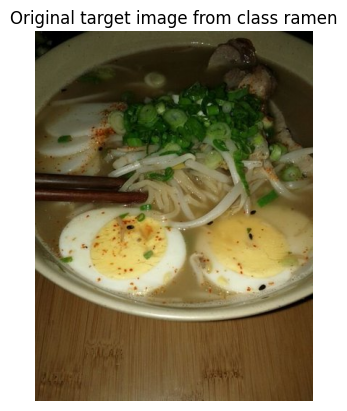

<Figure size 640x480 with 0 Axes>

In [52]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "../Datasets/10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
# print(random_image_path)

# Now visualize this

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original target image from class {target_class}")
plt.axis(False)

#  Now let's plot our augmented image
plt.figure()
augmented_img = data_augmentation(img/255.)
plt.title(f"Augmented target image from class {target_class}")
plt.axis(False)
plt.imshow(augmented_img)

## Model 1: Feature extraciont transfer learning on only 1% of the data with data augmentation

In [26]:
"""
Somehow it does not work if I do not put the data_augmentation layer here too. or if i run it first without running the code to visualize a
picture vs the augmented picture.
"""

#----
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

#----
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool the output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Put a dense layer as the output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model of input and output
model_1 = tf.keras.Model(inputs,outputs)

# Compile
model_1.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

history_1 = model_1.fit(train_data_1_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_1_percent),
                              validation_data = test_data,
                              validation_steps = int(0.25*len(test_data)),
                              callbacks = [hp.create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240802-162816
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 12s/step - accuracy: 0.0741 - loss: 2.3883 - val_accuracy: 0.1513 - val_loss: 2.2100
Epoch 2/5


2024-08-02 16:28:46.143198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-02 16:28:46.143269: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9785962045562028220
2024-08-02 16:28:46.143444: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 579287301565784150
2024-08-02 16:28:46.143471: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7107067337985516780
2024-08-02 16:28:46.143481: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1377958154121840364
2024-08-02 16:28:46.143489: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6880578330291570316
2024-08-02 16:28:46.143503: I tensorflow/core/framework/local_rendezvous

3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1332 - val_loss: 2.2204
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 10s/step - accuracy: 0.1528 - loss: 2.1449 - val_accuracy: 0.2352 - val_loss: 2.0971
Epoch 4/5


2024-08-02 16:29:38.570442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-02 16:29:38.570709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1995979460155146348
2024-08-02 16:29:38.570801: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9785962045562028220
2024-08-02 16:29:38.570851: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18165826848035046238
2024-08-02 16:29:38.570886: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3625147293111895226
2024-08-02 16:29:38.570917: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1377958154121840364
2024-08-02 16:29:38.570944: I tensorflow/core/framework/local_rendezvo

3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2336 - val_loss: 2.1210
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2254 - loss: 2.0843

2024-08-02 16:30:08.368414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-02 16:30:08.368456: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 677163716142520587
2024-08-02 16:30:08.368571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[Shape/_4]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step - accuracy: 0.2405 - loss: 2.0741 - val_accuracy: 0.3529 - val_loss: 1.9770


In [27]:
# model summary
model_1.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [28]:
# Evaluate on test data

result_1 = model_1.evaluate(test_data)
result_1

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.3288 - loss: 2.0081


[2.009648561477661, 0.3208000063896179]

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [29]:
train_dir_10_percent = "../Datasets/10_food_classes_10_percent/train/"
test_dir = "../Datasets/10_food_classes_10_percent/test/"

In [30]:
# Set data inputs
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)


Found 750 files belonging to 10 classes.


Found 2500 files belonging to 10 classes.


In [31]:
# Create Model_2 with data augmentation built in

import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomRescaling(0.2) # If we use ResNet we need this
], name = "data_augmentation")

# Setup the input shape into our model

input_shape = (224,224,3)

# Create a frozen base model (or backbone)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create inputs and outputs and layers in between
inputs = tf.keras.Input(shape=input_shape, name="input_shape")
x = data_augmentation(inputs)
x = base_model(x, training = False)  # To pass augmented images to base model but keep it in inference mode, also ensures that batchnorm layers don't get updated.

# Pool
x = tf.keras.layers.GlobalAveragePooling2D(name="goblal_average_pooling_2D")(x)

# Outputs
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create Model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])
model_2.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_shape (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ goblal_average_pooling_2D       │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## Creating a ModelCheckpoint callback
Callback intermediately saves our model in each epoch or in some epochs depending on setup

In [32]:
# Create a ModelCheckpoint Callback to save our model's weights

checkpoint_path = "ten_percent_model_checkpoints_weighs/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that save the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose = 1)

In [33]:
history_2 = model_2.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent), #leaving this on makes sometimes have 0 in accuracy???
                        validation_data = test_data,
                        validation_steps = int(0.25* len(test_data)),
                        callbacks = [hp.create_tensorboard_callback(dir_name="transfer_learning",experiment_name="10_percent_data_aug"),
                                     checkpoint_callback]
                        )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240802-163359
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2341 - loss: 2.1737
Epoch 1: saving model to ten_percent_model_checkpoints_weighs/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.2381 - loss: 2.1675 - val_accuracy: 0.6562 - val_loss: 1.4787
Epoch 2/5


2024-08-02 16:35:05.858328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-02 16:35:05.858349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_10_1/efficientnetv2-b0_1/block5c_drop_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_218]]
2024-08-02 16:35:05.858611: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15755218066462326736
2024-08-02 16:35:05.858619: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1453808672213468930
2024-08-02 16:35:05.858624: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4982965005254640098
2024-08-02 16:35:05.858639


Epoch 2: saving model to ten_percent_model_checkpoints_weighs/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6612 - val_loss: 1.4938
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5733 - loss: 1.5362
Epoch 3: saving model to ten_percent_model_checkpoints_weighs/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.5753 - loss: 1.5320 - val_accuracy: 0.7319 - val_loss: 1.1194
Epoch 4/5


2024-08-02 16:37:41.852272: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-02 16:37:41.852711: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17033978838375890802
2024-08-02 16:37:41.852725: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4982965005254640098
2024-08-02 16:37:41.852743: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5163848520554086666
2024-08-02 16:37:41.852764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_10_1/efficientnetv2-b0_1/block5c_drop_1/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_220]]
2024-08-02 16:37:41.852785


Epoch 4: saving model to ten_percent_model_checkpoints_weighs/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 530ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 1.0652
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7041 - loss: 1.2071

2024-08-02 16:40:29.319067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-02 16:40:29.319469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[ArgMax/_6]]
2024-08-02 16:40:29.319697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11851714940108304246



Epoch 5: saving model to ten_percent_model_checkpoints_weighs/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.7043 - loss: 1.2045 - val_accuracy: 0.8235 - val_loss: 0.8310


In [34]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8548 - loss: 0.5691


[0.5711647868156433, 0.8596000075340271]

In [35]:
# Check model_2 results on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 620ms/step - accuracy: 0.7665 - loss: 0.9072


[0.8962181806564331, 0.7716000080108643]

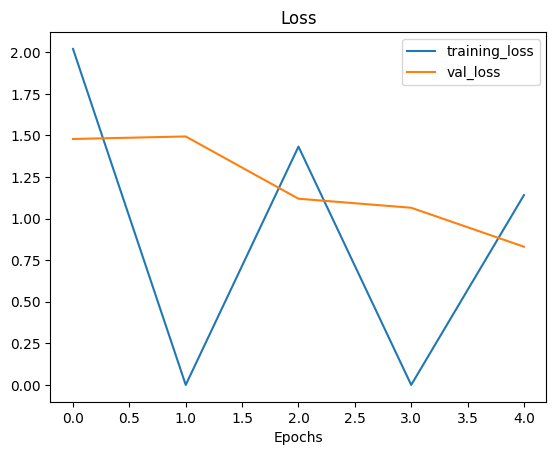

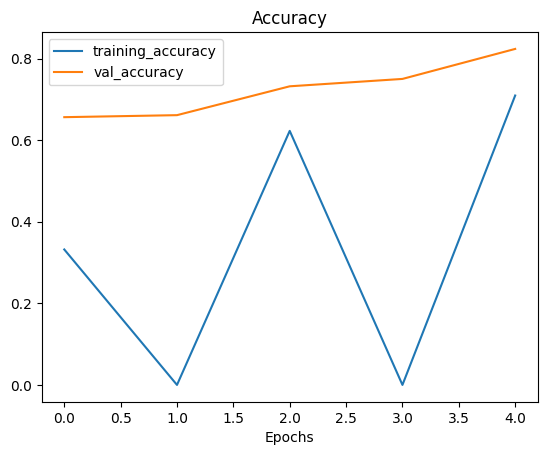

In [36]:
# plot model 2 loss curves

hp.plot_loss_curves(history_2)

### Loading in checkpointed weights
Returns a model into a specific checkpoint

In [37]:
# load the weights

model_2.load_weights(checkpoint_path)

In [38]:
# Evaluate the re-loaded model to see if it has the same performance (which means weights were loaded correctly)

loaded_weights_model_results = model_2.evaluate(test_data)
loaded_weights_model_results

79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 723ms/step - accuracy: 0.7696 - loss: 0.8910


[0.8962181806564331, 0.7716000080108643]

In [39]:
results_10_percent_data_aug == loaded_weights_model_results
# Yes they are the same!  around 

True

## Model 3: Finetuning an existing model on 10% of data

* Note: Fine-tuning usually works best when it's done after training a feature extraction model for a few epochs with large amounts of custom data

In [ ]:
# Since we already trained model_2, let's see if we can fine tuned it and make it model_3.

In [276]:
# Layers in model 2:

model_2.layers

[<InputLayer name=input_shape, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=goblal_average_pooling_2D, built=True>,
 <Dense name=output_layer, built=True>]

In [277]:
# Are these layers trainable?

for layer in model_2.layers:
    print(layer, layer.trainable)

<InputLayer name=input_shape, built=True> True
<Sequential name=data_augmentation, built=True> True
<Functional name=efficientnetv2-b0, built=True> False
<GlobalAveragePooling2D name=goblal_average_pooling_2D, built=True> True
<Dense name=output_layer, built=True> True


In [278]:
# Functional layer is the base model is not trainable (We set it as not trainable before)

In [293]:
# What layers are in our base_model (EfficientnetB0):

for i, layer in enumerate(model_2.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_layer_95 False
1 rescaling_69 False
2 normalization_68 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a

In [294]:
# How many trainable variables are in our base model?

print(len(model_2.layers[2].trainable_variables))

10


### Fine-tuning

In [47]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
# First set everything to True
base_model.trainable = True

# Now freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss= "categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001), # we do not want to update too fast when fine-tuning
                # Typically lower the learning rate by 10x when fine-tuning
                metrics = ["accuracy"])

In [325]:
# Fine-tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_tune_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                                    epochs = fine_tune_epochs,
                                                    # steps_per_epoch = len(train_data_10_percent),
                                                    validation_data = test_data,
                                                    # validation_steps = int(0.25* len(test_data)),
                                                    # IMPORTANT:
                                                    initial_epoch = history_2.epoch[-1], # Start training from previous last epoch
                                                    callbacks = [hp.create_tensorboard_callback(dir_name="transfer_learning",
                                                                          experiment_name="fine_tune_10_percent_data_aug")],
                                                                        #   checkpoint_callback] # No tenia que salvarlo porque queriamos usar el model_2 checkpoint como base para model_3 y model_4
                                                    )

Saving TensorBoard log files to: transfer_learning/fine_tune_10_percent_data_aug/20240802-142625
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7873 - loss: 0.8413 
Epoch 5: saving model to ten_percent_model_checkpoints_weighs/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 386s 15s/step - accuracy: 0.7873 - loss: 0.8407 - val_accuracy: 0.8300 - val_loss: 0.6051
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8156 - loss: 0.7374
Epoch 6: saving model to ten_percent_model_checkpoints_weighs/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 227s 10s/step - accuracy: 0.8154 - loss: 0.7382 - val_accuracy: 0.8384 - val_loss: 0.5732
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8142 - loss: 0.7243
Epoch 7: saving model to ten_percent_model_checkpoints_weighs/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 223s 9s/step - accuracy: 0.8140 - loss: 0.7245 - val_accuracy: 0.8420 - val_loss: 0.5410
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step -

In [328]:
# Evaluate the fine-tuned model3 (model_2 fint-tuned for another 5 epochs):

results_fine_tuned_10_percent = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8519 - loss: 0.4901


In [329]:
# Original model_2 results vs Model_3 (fine-tuned model_2) new results

results_10_percent_data_aug , results_fine_tuned_10_percent

([0.7028560638427734, 0.8131999969482422],
 [0.4861889183521271, 0.8515999913215637])

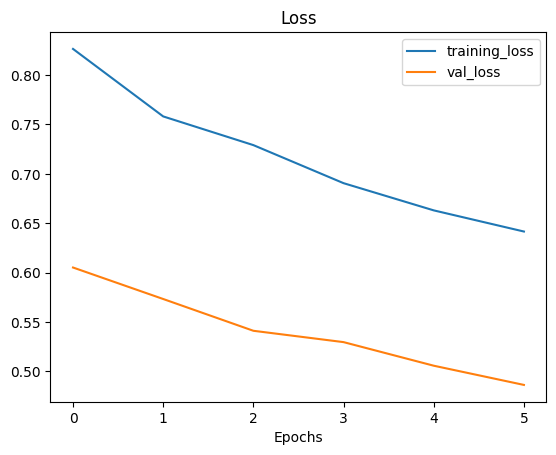

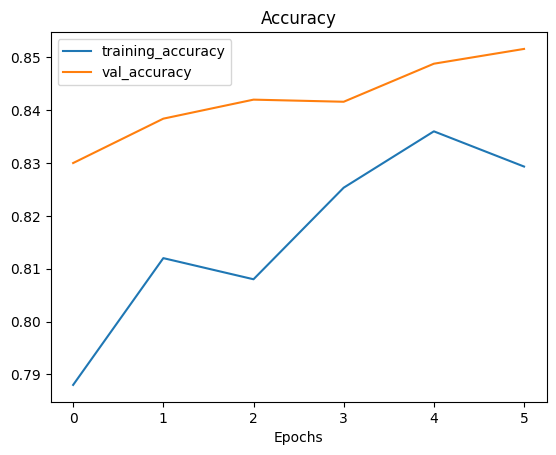

In [330]:
hp.plot_loss_curves(history_fine_tune_10_percent_data_aug)

In [40]:
# we need a way to evaluate our model's performance before and after fine-tuning.

def compare_historys(original_history, new_history, initial_epochs = 5):
    """
        Compares two Tensorflow History objects
    """
    # Original measurements:
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # New measurements:
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"] 

    # Make plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label = "Training Accuracy")
    plt.plot(total_val_acc, label= "Val Accuracy")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    # Make plots
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss, label = "Training Loss")
    plt.plot(total_val_loss, label= "Val Loss")
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = "Start Fine Tuning")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")



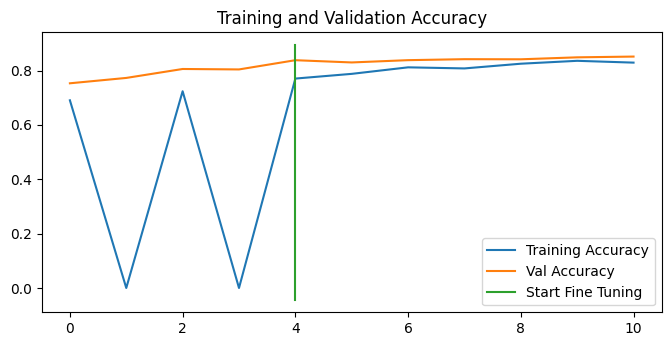

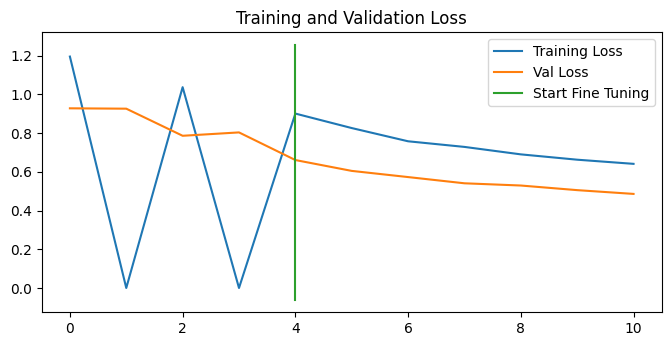

In [332]:
compare_historys(history_2, history_fine_tune_10_percent_data_aug)

## Model 4: Fine-tuning an existing model on all of the data

In [41]:
train_dir = "../Datasets/10_food_classes_all_data/train"
test_dir = "../Datasets/10_food_classes_all_data/test"

hp.walk_through_dir("../Datasets/10_food_classes_all_data")

There are 2 directories and 0 images in '../Datasets/10_food_classes_all_data'.
There are 10 directories and 0 images in '../Datasets/10_food_classes_all_data/test'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '../Datasets/10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '../Datasets/10

In [42]:
# Setup data inputs

IMG_SIZE = (224,224)

train_data_all_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                          image_size = IMG_SIZE,
                                                                          label_mode = "categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [43]:
# For our model 4, we will use the model_2 reloaded and fine-tune on all of the data

model_2.load_weights(checkpoint_path)

In [44]:
# Let's evaluate model_2 now

model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 225ms/step - accuracy: 0.7707 - loss: 0.9027


[0.8962180614471436, 0.7716000080108643]

In [45]:
# Check which layers are tunable in the whole model

for layer_number, layer in enumerate(model_2.layers):
    print( layer_number, layer.name, layer.trainable)

0 input_shape True
1 data_augmentation True
2 efficientnetv2-b0 False
3 goblal_average_pooling_2D True
4 output_layer True


In [48]:
# let's see what layers are trainable in our base model

for layer_number, layer in enumerate(model_2.layers[2].layers):
    print( layer_number, layer.name, layer.trainable)

0 input_layer_5 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [49]:
# Compile model_2 (model_4)
model_2.compile(loss= "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(0.0001), #should be 10x lower than usual since we are fine-tuning
                metrics = ["accuracy"])

In [53]:
# Fit and train
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_all_data,
                                           epochs = fine_tune_epochs,
                                            validation_data = test_data,
                                            # steps_per_epoch = len(train_data_all_data) # He is not including this?
                                            # validation_steps = (0.25* len(test_data)),
                                            initial_epoch = history_2.epoch[-1], # this is because we need to continue training from the last epoch of the feature extraction model                    
                                            callbacks = [hp.create_tensorboard_callback(dir_name="transfer_learning",
                                                                                        experiment_name = "full_10_classes_fine_tune_last_10")]
                                            )

# Takes too long to finish... maybe i should upload to google collab and try it there.

# Takes about 20 to 30 min for the first epoch.

In [ ]:
# results_fine_tune_full_data = model_2.evaluate(test_data)
# results_fine_tune_full_data

In [ ]:
# compare_historys(original_history=history_2,
#                  new_history= history_fine_10_classes_full,
#                  initial_epochs=5)

## Viewing our experiments on Tensorboard

In [55]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [61]:
#Upload tensorboard records

!tensorboard serve --logdir ./transfer_learning \
# now this are not recognize with "serve", in video he used "dev upload", but maybe not applicable anymore
    # --name "Transfer Learning experiments with 10 Food101 Classes" \
    # --description "Series of transfer learning experiments" \
    # --one_shot #exits the uploader once its finished uploading

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6007/ (Press CTRL+C to quit)
^C


# FINISHED!